# Clasificación de curvas de acuerdo a su forma utilizando aprendizaje no supervisado


En este cuaderno de trabajo, se aplicarán algoritmos de **aprendizaje no supervisado** para la clasificación de curvas de carga representativas de clientes. Previamente, se realizó un **proceso ETL** en el que se consolidaron datos de múltiples clientes en un único conjunto de datos anual. Estos datos fueron almacenados en **MongoDB** y contienen mediciones de potencia aparente cada **30 minutos**, desde las **00:00 hasta las 23:30**.

El objetivo principal de este análisis es **agrupar las curvas de carga según su forma**, sin que influya el desplazamiento en el eje Y. Para ello, se realizarán una serie de transformaciones y ajustes antes de aplicar los algoritmos de clustering.

### Algoritmos de Clustering Utilizados
Se han seleccionado los siguientes algoritmos de **aprendizaje no supervisado**:

- **K-Means** 🟢  
- **Gaussian Mixture Model (GMM)** 🔵  
- **BIRCH** 🟡  
- **Spectral Clustering** 🟣  

Cada uno de estos algoritmos se ajustará y evaluará para determinar cuál realiza una mejor agrupación de las curvas según su forma.

---

### 0.- Librerías y Funciones a Utilizar  

Se importan las librerías necesarias para el procesamiento de datos, visualización y clustering.

- Librerías Principales  
    - `numpy`, `pandas` → Manejo y transformación de datos.  
    - `matplotlib` → Gráficos y visualización.  
    - `sklearn` → Algoritmo de clustering y métricas.  
    - `pymongo` → Conexión con MongoDB.  

- Algoritmos de Clustering  
    - `KMeans`, `GaussianMixture`, `BIRCH`, `SpectralClustering`.  

- Funciones Auxiliares  
    - Ajuste de curvas al origen *(0,0)*.  
    - Visualización de resultados.
    - Hyperparametrización para los algoritmos
    - Agrupación para cada tipo de algoritmos
    - Evaluar calidad de las agrupaciones

In [1]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import SpectralClustering, KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pymongo import MongoClient
from dotenv import load_dotenv
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import warnings
import shutil
import os
import sys


ruta_src = os.path.abspath("../utils")
sys.path.append(ruta_src)
ruta_imgs_latex = os.path.abspath("../latex/imgs")
sys.path.append(ruta_imgs_latex)
warnings.filterwarnings("ignore")

In [2]:
def obtener_cliente_db():
    # Cargar las variables del archivo .env
    load_dotenv()

    # Obtener las credenciales y el cluster de MongoDB
    username = os.getenv("DB_USER_T")
    password = os.getenv("DB_PASS_T")
    cluster = os.getenv("DB_CLUSTER_T")

    # Construir la uri con las credenciales
    uri = f"mongodb+srv://{username}:{password}@{cluster.lower()}.gypwd.mongodb.net/?retryWrites=true&w=majority&appName={cluster}"

    # Crear un cliente y conectarlo al servidor
    client = MongoClient(uri, 
                        server_api=ServerApi('1'),
                        connectTimeoutMS=60000,
                        socketTimeoutMS=60000,
                        serverSelectionTimeoutMS=60000,
                        tls=True)

    # Si el cliente existe, retornarlo
    if client is not None:
        return client

In [3]:
def ajustar_curva_al_origen(datos_curvas):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()

    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el primer dato de cada curva
        primer_dato = curva[0]

        # Modificar los datos de la curva para que el primero siempre empiece en (0,0)
        for i in range(len(curva)):
            curva[i] = curva[i] - primer_dato

    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

def ajustar_curva_a_05(datos_curvas):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()
    
    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el centro vertical de la curva
        centro = (curva.min() + curva.max()) / 2
        
        # Modificar los datos de la curva para que toda 
        # la curva quede centrada verticalmente en rango [0,1]
        for i in range(len(curva)):
            curva[i] = curva[i] - centro + 0.5
    
    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

def ajustar_curva_origen2(datos_curvas, n=5):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()

    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el primer dato de cada curva
        sum_n = 0
        for i in range(n):
            sum_n += curva[i]
        
        valor_restar = sum_n / n

        # Modificar los datos de la curva para que el primero siempre empiece en (0,0)
        for i in range(len(curva)):
            curva[i] = curva[i] - valor_restar

    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

In [4]:
def graficar_clusters(curves_data, labels, n=5):
    unique_clusters = np.unique(labels)
    
    # Crear una figura con el número de subgráficos correspondientes al número de clústeres
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 3.5 * len(unique_clusters)), sharex=True)
    
    if len(unique_clusters) == 1:
        axes = [axes]  # Si solo hay un clúster, hacer que axes sea iterable para mantener el formato
    
    # Para cada clúster, graficar las curvas
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]

        # Tomar hasta 'n' curvas para graficar
        curvas_a_graficar = curvas_cluster[:min(n, len(curvas_cluster))]
        
        for curva in curvas_a_graficar:
            axes[idx].plot(curva, alpha=0.7, linestyle='--')  # Graficar cada curva con transparencia

        axes[idx].set_title(f'Curvas agrupadas en el Clúster {cluster}')
        axes[idx].set_xlabel('Hora del día')
        axes[idx].set_ylabel('Potencia aparente escalada')
        axes[idx].set_yticks(np.arange(0, 1, 0.1))
        axes[idx].grid(True)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def graficar_curva_tipo_cluster(curves_data, labels):
    unique_clusters = np.unique(labels)
    plt.figure(figsize=(10, 6))
    
    # Colores para cada cluster
    colors = plt.cm.tab10(range(len(unique_clusters)))  # hasta 10 colores distintos
    
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]
        
        # Calcular la curva media
        curva_media = np.mean(curvas_cluster, axis=0)
        
        # Graficar la curva media
        plt.plot(curva_media, label=f'Clúster {cluster}', color=colors[idx])
    
    plt.title('Curvas tipo por clúster')
    plt.xlabel('Hora del día')
    plt.ylabel('Potencia aparente escalada')
    plt.xticks(np.arange(0, len(curva_media), step=2))  # cada 2 horas, ajusta según tus datos
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
def evaluate_clustering_models(data, param_grid, rand_state=42):
    best_models = {}
    results = []

    for model_name, params in param_grid.items():
        param_combinations = list(product(*params.values()))
        param_keys = list(params.keys())

        best_score = -1
        best_params = None
        best_model = None

        for param_set in param_combinations:
            param_dict = dict(zip(param_keys, param_set))

            # Crear el modelo según su tipo
            if model_name == "KMeans":
                model = KMeans(**param_dict, random_state=rand_state)
            elif model_name == "GaussianMixture":
                model = GaussianMixture(**param_dict, random_state=rand_state)
            elif model_name == "Birch":
                model = Birch(**param_dict)
            elif model_name == "SpectralClustering":
                model = SpectralClustering(**param_dict, random_state=rand_state)

            # Entrenar el modelo y obtener etiquetas
            try:
                labels = model.fit_predict(data)

                # Calcular métricas
                silhouette = silhouette_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                corr_ic, _ = calcular_correlacion_intra_cluster(data, labels)

                # Guardar resultados
                results.append((model_name, param_dict, silhouette, calinski_harabasz, davies_bouldin))

                # Actualizar mejor modelo basado en Silhouette Score (puedes cambiar este criterio)
                if corr_ic > best_score:
                    best_score = corr_ic
                    best_params = param_dict
                    best_model = model

            except:
                continue  # Si hay error, seguimos con la siguiente combinación

        # Guardar el mejor modelo para este tipo
        best_models[model_name] = {
            "model": best_model,
            "params": best_params,
            "Correlación intra-cluster promedio": best_score
        }

    return best_models, results


In [6]:
def apply_clustering(parametros_opt, datos_curvas, num_random_state=42):
    # Función para aplicar clustering
    kmeans = KMeans(**parametros_opt["KMeans"], random_state=num_random_state).fit(datos_curvas)
    gmm = GaussianMixture(**parametros_opt["GaussianMixture"], random_state=num_random_state).fit(datos_curvas)
    birch = Birch(**parametros_opt["Birch"]).fit(datos_curvas)
    spectral = SpectralClustering(**parametros_opt["SpectralClustering"], random_state=num_random_state, assign_labels='kmeans').fit(datos_curvas)
    
    return {
        'KMeans': kmeans.labels_,
        'GaussianMixture': gmm.predict(datos_curvas),
        'Birch': birch.labels_,
        'SpectralClustering': spectral.labels_
    }

In [7]:
def homologar_numeros_clusteres(clusteres, curvas_ajustadas):

    # 0. Obtener los nombres de los algoritmos
    algoritmos = list(clusteres.keys())

    # 1. PCA común
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(curvas_ajustadas)

    clusteres_reetiquetados = {}

    for metodo in algoritmos:
        labels = np.asarray(clusteres[metodo], dtype=int)

        df = pd.DataFrame({
            "pc1": pca_result[:, 0],
            "pc2": pca_result[:, 1],
            "label": labels
        })

        # 2. Centroides en PCA por etiqueta
        centroides = (
            df.groupby("label")[["pc1", "pc2"]]
              .mean()
              .reset_index()
              .rename(columns={"label": "label_original"})
        )

        # 3. Ordenar por pc1 y crear etiqueta nueva
        centroides = centroides.sort_values("pc1").reset_index(drop=True)
        centroides["label_nuevo"] = np.arange(len(centroides))

        # 4. mapa y re-etiquetado
        mapa = dict(zip(centroides["label_original"], centroides["label_nuevo"]))
        labels_re = np.vectorize(mapa.get)(labels)

        # 5. Re-etiquetar todos los clusteres y retornar
        clusteres_reetiquetados[metodo] = labels_re

    return clusteres_reetiquetados

In [8]:
def evaluar_clustering(curvas_ajustadas_origen, clusters):
    resultados = {
        "Métrica": [
            "Correlación intra-clúster promedio",
            "Davies-Bouldin Index",
            "Calinski-Harabasz Index",
            "Silhouette Score"
        ]
    }
    
    for algoritmo, labels in clusters.items():
        labels = np.array(labels)
        
        # Puntaje de silueta
        silhouette_avg = silhouette_score(curvas_ajustadas_origen, labels)
        
        # Davies-Bouldin Index (DBI)
        dbi = davies_bouldin_score(curvas_ajustadas_origen, labels)
        
        # Calinski-Harabasz Index (CHI)
        chi = calinski_harabasz_score(curvas_ajustadas_origen, labels)
        
        # Sum of Squared Errors (SSE)
        unique_labels = np.unique(labels)
        centroids = np.array([curvas_ajustadas_origen[labels == lbl].mean(axis=0) for lbl in unique_labels])
        sse = compute_sse(curvas_ajustadas_origen, labels, centroids)
        
        # Correlación intra-clúster
        corr_intra, _ = calcular_correlacion_intra_cluster(curvas_ajustadas_origen, labels)
        
        # Obtener todos los resultados en un arreglo y redondear a 4 decimales.
        resultados[algoritmo] = [round(metrica, 4) for metrica in [corr_intra, dbi, chi, silhouette_avg]]
    
    return pd.DataFrame(resultados)

def compute_sse(X, labels, centroids):
    sse = 0
    for i in range(len(centroids)):
        cluster_points = X[np.array(labels) == i]
        if len(cluster_points) > 0:
            sse += np.sum((cluster_points - centroids[i]) ** 2)
    return sse

def calcular_correlacion_intra_cluster(curves_data, labels, indices_clientes_elegidos = []):
    """
    Calcula la correlación promedio de cada curva con la curva media de su clúster.
    Maneja casos donde hay clústeres vacíos o con un solo punto.
    """
    
    if len(indices_clientes_elegidos) == 0:
        unique_clusters = np.unique(labels)
        correlaciones = []

        for cluster in unique_clusters:
            curvas_cluster = curves_data[labels == cluster]

            # Calcular curva media
            curva_media = np.mean(curvas_cluster, axis=0)

            # Evitar división por cero en curvas constantes
            for curva in curvas_cluster:
                if np.std(curva) == 0 or np.std(curva_media) == 0:
                    corr = 1.0  # Considerar correlación perfecta si no hay variación
                else:
                    corr = np.corrcoef(curva, curva_media)[0, 1]
                correlaciones.append(corr)
    else:
        curves_data_2 = np.array(curves_data)
        unique_clusters = np.unique(labels)
        dict_curva_tipo_x_cluster = {}
        correlaciones = []
        
        for cluster in unique_clusters:
            dict_curva_tipo_x_cluster[cluster] = np.mean(curves_data[labels == cluster],axis=0)
         
        clientes_elegidos = curves_data_2[sorted(indices_clientes_elegidos)]
        
        for cliente, label in zip(clientes_elegidos, np.array(labels)[sorted(indices_clientes_elegidos)]):
            
            
            if np.std(cliente) == 0 or np.std(dict_curva_tipo_x_cluster[label]) == 0:
                corr = 1.0
            else:
                corr = np.corrcoef(cliente, dict_curva_tipo_x_cluster[label])[0, 1]
            correlaciones.append(corr)


    return np.nanmean(correlaciones), correlaciones

In [9]:
def elbow_method(data, k_range=(1, 10)):
    """
    Aplica el método del codo y grafica la inercia y la distorsión para diferentes valores de k.
    
    Parámetros:
        data (array-like): Datos a agrupar.
        k_range (tuple): Rango de valores de k a evaluar (mínimo, máximo).
    """
    ks = list(range(k_range[0], k_range[1] + 1))
    inertias = []
    distortions = []
    
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init="k-means++")
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        # Distorsión: distancia promedio al centroide
        distortion = np.mean(np.min(
            np.linalg.norm(data[:, np.newaxis] - kmeans.cluster_centers_, axis=2), axis=1))
        distortions.append(distortion)
    
    plt.figure(figsize=(9, 5))
    
    # Gráfico de Inercia
    plt.plot(ks, inertias, marker='o', linestyle='-')
    plt.axvline(4, color='red', linestyle='--', alpha=0.6)
    plt.xticks(np.arange(k_range[0], k_range[1]+1, 1))
    plt.xlabel('Número de clústeres (K)')
    plt.ylabel('Inercia')
    plt.title('Método del codo')
    plt.grid()
    plt.tight_layout()
    
    plt.savefig(rf'{ruta_imgs_latex}/cm_elbow_method.png', format='png',dpi=400)
    plt.show()


### 1.- Obtención y Preprocesamiento de Datos
- **Obtención de datos** desde la base de datos MongoDB.
- **Ajuste de curvas** para que todas comiencen desde el punto origen **(0,0)**.  
   - Esto es importante porque algunas curvas, aunque tienen la misma forma, están desplazadas en el eje Y (potencia aparente), lo que podría afectar la agrupación.

Nota: Los datos de las curvas ya fueron **normalizados** y **escalados** cuando se realizó previamente el proceso ETL.

In [10]:
# Obtener cliente para conectar a la db
db_cliente = obtener_cliente_db()

# Obtener los registros de las curvas
cursor = db_cliente.CurvasTipo.CurvasTipoAnuales.find({}, {"_id": 0})
df_registros_curvas = pd.DataFrame(list(cursor))
df_registros_curvas

Cliente     00:00     00:15     00:30     00:45  \
0                            90001618  0.019028  0.019223  0.018104  0.020987   
1                            90002610  0.937334  0.941943  0.936459  0.941967   
2                             1280105  0.228515  0.234197  0.233679  0.219447   
3                            90000436  0.004363  0.004421  0.004374  0.004519   
4                             1823479  0.005748  0.005294  0.004862  0.004698   
..                                ...       ...       ...       ...       ...   
383                        SIGMAPLAST  0.629019  0.630376  0.633878  0.628827   
384                          SINTOFIL  0.570382  0.585197  0.573659  0.597055   
385  SOCIEDAD INDUSTRIAL RELI  CYRANO  0.507828  0.548428  0.602141  0.641924   
386                    TEXTILES TEXSA  0.652327  0.659354  0.673829  0.678086   
387                   VICUNHA ECUADOR  0.018601  0.016489  0.028610  0.032117   

        01:00     01:15     01:30     01:45     02:00  ...     21:30  \
0    0.018415  0.020533  0.030271  0.019612  0.023810  ...  0.110774   
1    0.943595  0.942157  0.946024  0.934046  0.924062  ...  0.941595   
2    0.213188  0.218411  0.217394  0.205001  0.215991  ...  0.257457   
3    0.004426  0.004625  0.004653  0.004466  0.004475  ...  0.008552   
4    0.003838  0.123425  0.140769  0.139781  0.140076  ...  0.054105   
..        ...       ...       ...       ...       ...  ...       ...   
383  0.628891  0.645276  0.620338  0.625429  0.605990  ...  0.714449   
384  0.576146  0.579117  0.577594  0.575732  0.573957  ...  0.718854   
385  0.676887  0.664850  0.604600  0.519819  0.460527  ...  0.143328   
386  0.648810  0.629231  0.635267  0.638459  0.571459  ...  0.651484   
387  0.038422  0.046931  0.032595  0.044854  0.015252  ...  0.235963   

        21:45     22:00     22:15     22:30     22:45     23:00     23:15  \
0    0.122515  0.085852  0.118329  0.115584  0.109235  0.096428  0.103552   
1    0.946211  0.942878  0.939831  0.937686  0.938856  0.936726  0.937152   
2    0.258727  0.268788  0.268549  0.248610  0.259214  0.255545  0.256848   
3    0.009072  0.007137  0.007428  0.006692  0.006746  0.006324  0.006519   
4    0.053500  0.054307  0.052230  0.046928  0.015125  0.011485  0.011426   
..        ...       ...       ...       ...       ...       ...       ...   
383  0.731757  0.722260  0.691284  0.708349  0.708756  0.718092  0.726780   
384  0.682750  0.618568  0.668834  0.652609  0.609928  0.658959  0.648654   
385  0.236751  0.309762  0.366178  0.461476  0.496907  0.532044  0.538810   
386  0.642832  0.681969  0.655349  0.669919  0.692258  0.722694  0.710875   
387  0.141392  0.092120  0.123175  0.128275  0.147159  0.176647  0.147915   

        23:30     23:45  
0    0.102854  0.131166  
1    0.940069  0.938626  
2    0.246120  0.252066  
3    0.006599  0.006238  
4    0.008159  0.008059  
..        ...       ...  
383  0.729823  0.736136  
384  0.672968  0.686380  
385  0.510710  0.507754  
386  0.688904  0.682519  
387  0.163142  0.131872  

[388 rows x 97 columns]

In [11]:
curves_data = df_registros_curvas.iloc[:,1:].values
curves = df_registros_curvas.values

In [12]:
curvas_ajustadas = ajustar_curva_origen2(curves_data)

### 2.- Método del Codo para Número Óptimo de Clústers

Se ha definido inicialmente **4 clústers**, ya que se identificaron cuatro formas representativas en las curvas anuales. Sin embargo, para validar esta elección, se aplicará el **método del codo**.

Pasos:
- Ejecutar **K-Means** para distintos valores de \( k \) (2 a 20).
- Calcular la **Suma de Errores Cuadráticos (SSE)**.
- Graficar la curva **SSE vs. \( k \)** y detectar el "codo".

Este análisis permitirá verificar si 4 realmente es un número adecuado o si es necesario ajustarlo.

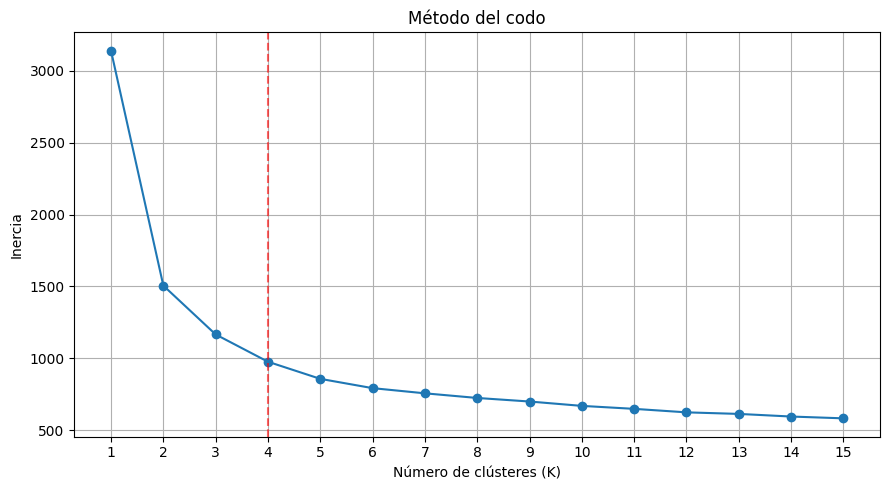

In [13]:
elbow_method(curvas_ajustadas, k_range=(1, 15))

Como se pude apreciar, a partir de k=4, la inercia comienza a minimizarse, formando una especie de 'codo', por lo que podemos asegurar que es un valor bueno e incluso óptimo para el número de agrupaciones que vamos a realizar.

### 3.- Optimización de Hiperparámetros
Para seleccionar los mejores parámetros para cada algoritmo, se definirá un **diccionario de hiperparámetros**, donde:

- Cada clave representa un algoritmo.
- Cada valor es un conjunto de parámetros que puede tomar dicho algoritmo.

Se explorarán combinaciones de hiperparámetros para encontrar la configuración **óptima**.

In [14]:
# Definir los hiperparámetros a probar por cada algoritmo de agrupación
param_grid = {
    "KMeans": {
        "n_clusters": [4],
        "init": ["k-means++", "random"],
        "n_init": [1, 2, 3, 5, 10, 20, 30]
    },
    "GaussianMixture": {
        "n_components": [4],
        "covariance_type": ["full", "diag", "spherical", "tied"],
        "n_init": [1, 2, 3, 5, 10, 20]
    },
    "Birch": {
        "n_clusters": [4],
        "threshold": [0.05, 0.075, 0.1, 0.125, 0.15, 0.2],
        "branching_factor": [10, 20, 25, 30, 40, 50]
    },
    "SpectralClustering": {
        "n_clusters": [4],
        "affinity": ["nearest_neighbors"],
        "n_neighbors": [4, 6, 8, 10, 15, 25, 35],
        "eigen_solver": ["arpack", "amg"]
    }
}


In [15]:
best_models, results = evaluate_clustering_models(curvas_ajustadas, param_grid)

In [16]:
dict_parametros_optimos = {}

for model_name, info in best_models.items():
    dict_parametros_optimos[model_name] = info["params"]
    print(f"Mejor configuración para {model_name}:")
    print(f"- Parámetros: {info['params']}")
    print(f"- Correlación intra-clúster promedio: {info["Correlación intra-cluster promedio"]:.4f}")
    print("")

Mejor configuración para KMeans:
- Parámetros: {'n_clusters': 4, 'init': 'k-means++', 'n_init': 3}
- Correlación intra-clúster promedio: 0.7399

Mejor configuración para GaussianMixture:
- Parámetros: {'n_components': 4, 'covariance_type': 'spherical', 'n_init': 1}
- Correlación intra-clúster promedio: 0.7394

Mejor configuración para Birch:
- Parámetros: {'n_clusters': 4, 'threshold': 0.15, 'branching_factor': 10}
- Correlación intra-clúster promedio: 0.7515

Mejor configuración para SpectralClustering:
- Parámetros: {'n_clusters': 4, 'affinity': 'nearest_neighbors', 'n_neighbors': 6, 'eigen_solver': 'arpack'}
- Correlación intra-clúster promedio: 0.7533



### 4.- Aplicación de los Algoritmos de Clustering
Una vez seleccionados los hiperparámetros óptimos, se procederá a **agrupar las curvas** con cada algoritmo y se analizarán los resultados.

In [17]:
print(dict_parametros_optimos)

{'KMeans': {'n_clusters': 4, 'init': 'k-means++', 'n_init': 3}, 'GaussianMixture': {'n_components': 4, 'covariance_type': 'spherical', 'n_init': 1}, 'Birch': {'n_clusters': 4, 'threshold': 0.15, 'branching_factor': 10}, 'SpectralClustering': {'n_clusters': 4, 'affinity': 'nearest_neighbors', 'n_neighbors': 6, 'eigen_solver': 'arpack'}}


In [18]:
clusters_sin_homologar = apply_clustering(dict_parametros_optimos, curvas_ajustadas)
clusters = homologar_numeros_clusteres(clusters_sin_homologar, curvas_ajustadas)

In [20]:
print(np.bincount(clusters["KMeans"]))
print(np.bincount(clusters["GaussianMixture"]))
print(np.bincount(clusters["Birch"]))
print(np.bincount(clusters["SpectralClustering"]))

[ 25 101 118 144]
[ 34 100  91 163]
[ 33  68 152 135]
[ 24  82 149 133]


### 5.- Visualización de Resultados
Para interpretar las agrupaciones, se utilizarán dos funciones de visualización:

- **Curva representativa por clúster**  
   - Se graficará una curva promedio o representativa por cada grupo identificado.

- **Gráfico con todas las curvas de cada clúster**  
   - Se visualizarán todas las curvas pertenecientes a un mismo clúster en un solo gráfico para evaluar la cohesión de los grupos formados.

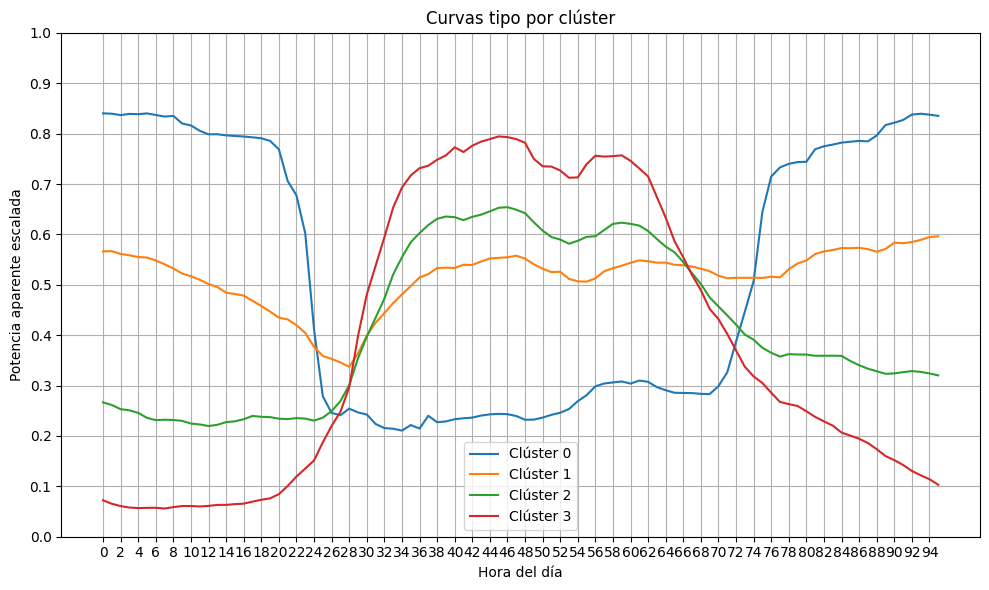

In [21]:
graficar_curva_tipo_cluster(curves_data, clusters["KMeans"])

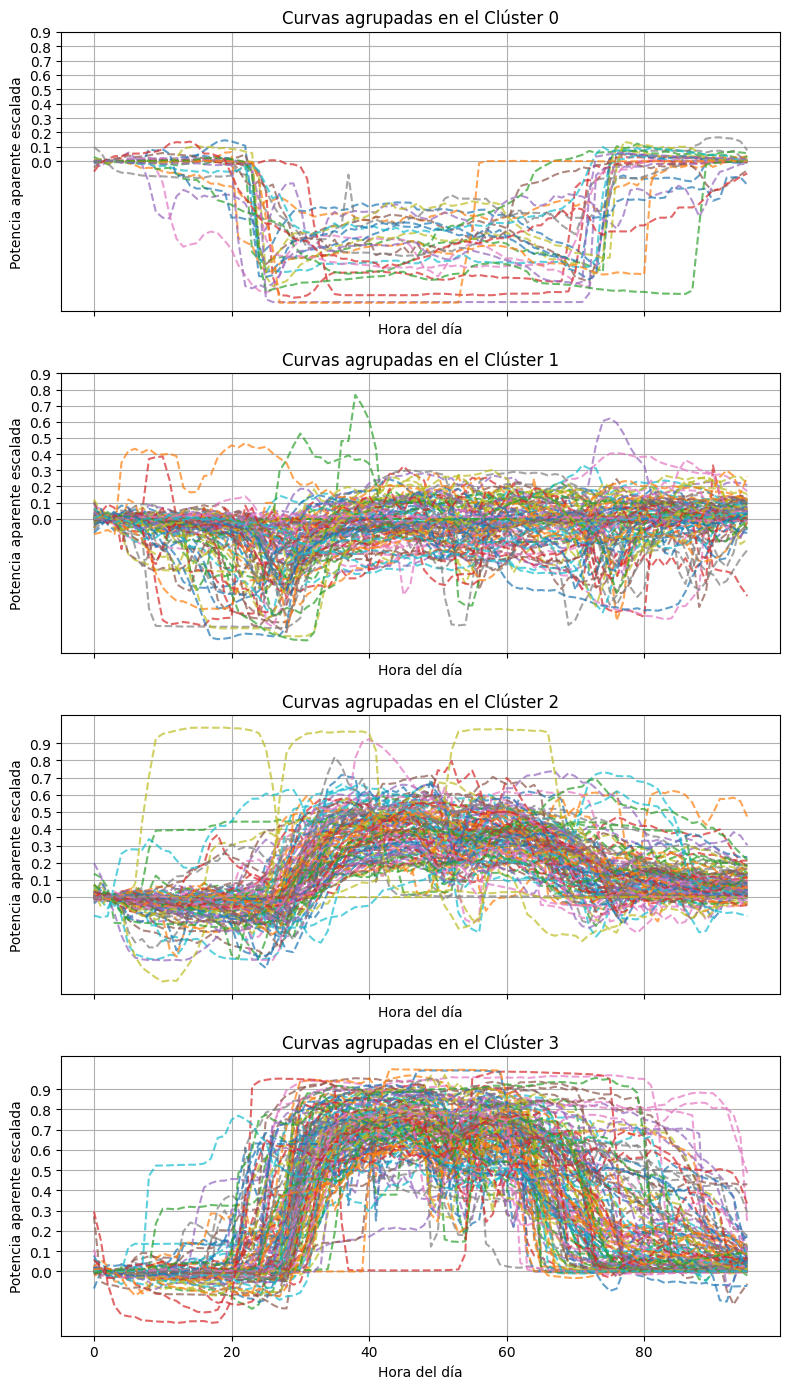

In [22]:
graficar_clusters(curvas_ajustadas, clusters["KMeans"], 200)

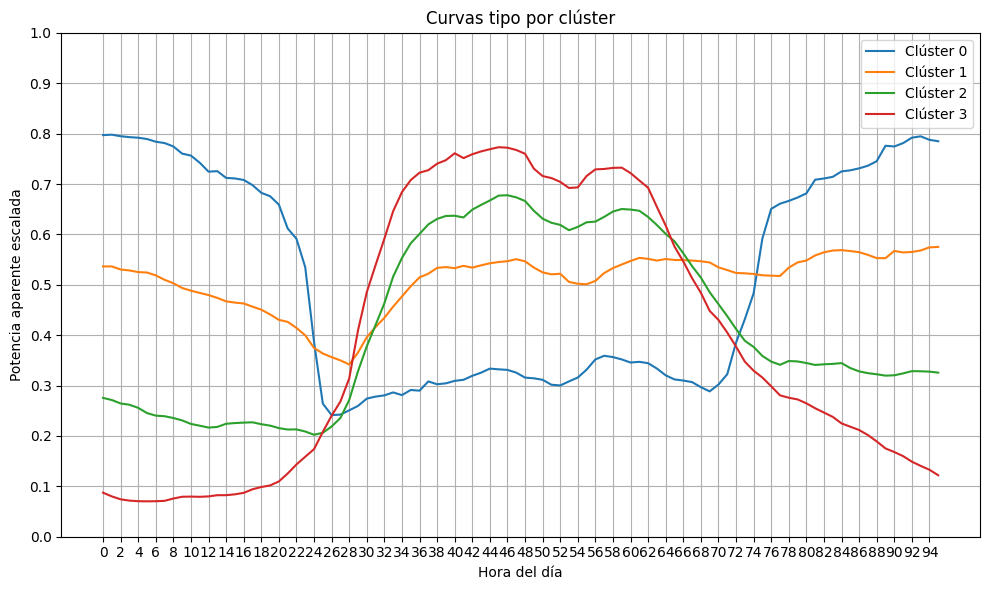

In [22]:
graficar_curva_tipo_cluster(curves_data, clusters["GaussianMixture"])

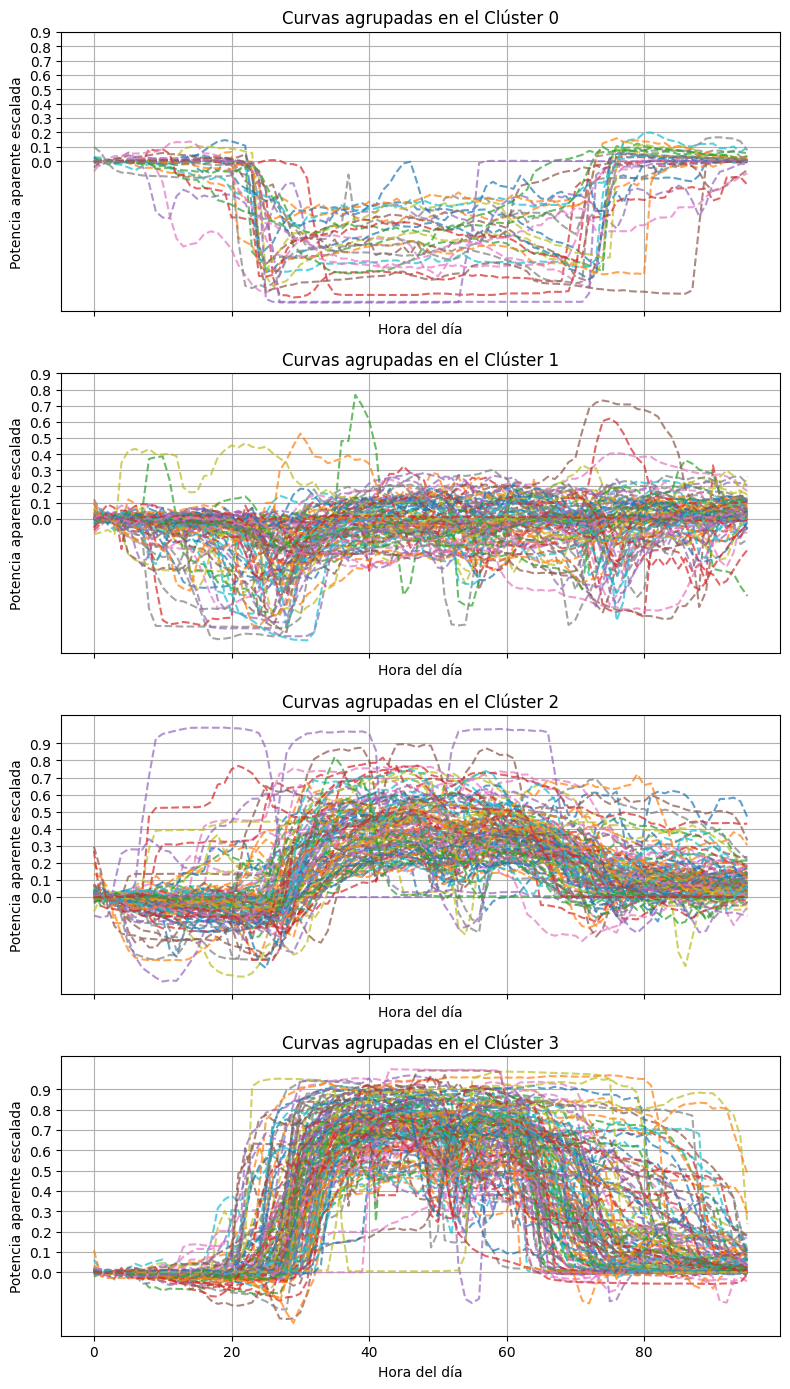

In [24]:
graficar_clusters(curvas_ajustadas, clusters["GaussianMixture"], 200)

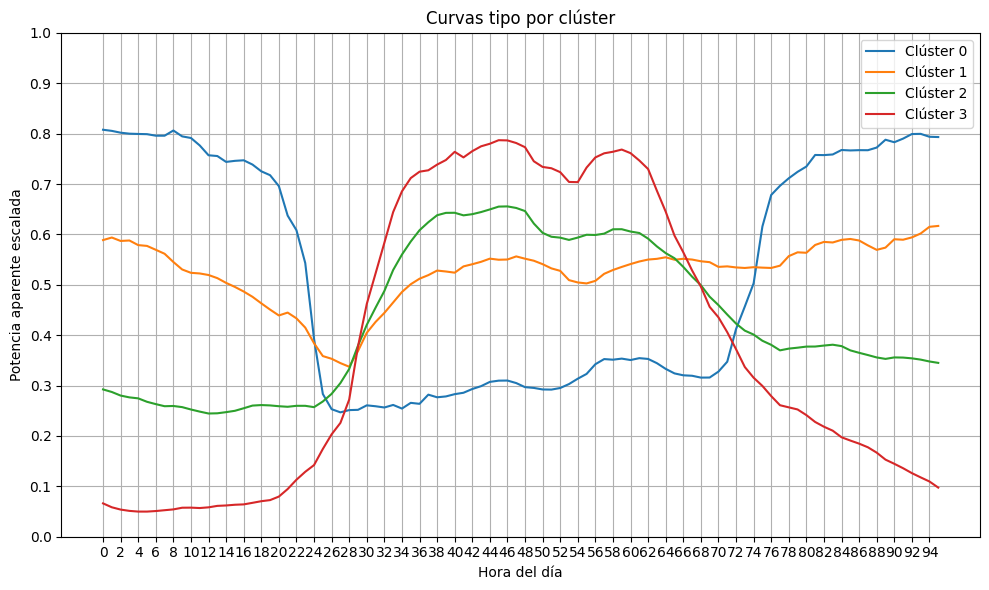

In [23]:
graficar_curva_tipo_cluster(curves_data, clusters["Birch"])

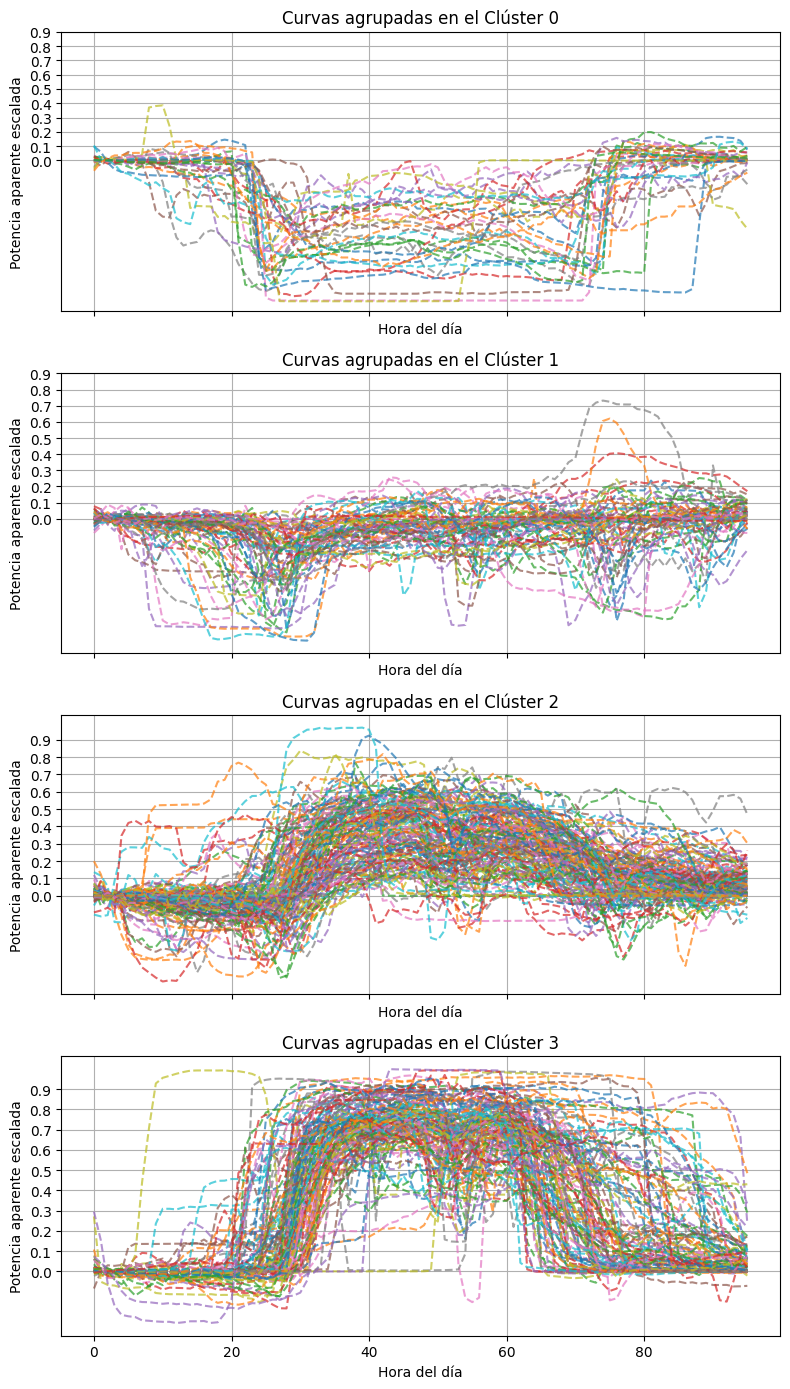

In [26]:
graficar_clusters(curvas_ajustadas, clusters["Birch"], 200)

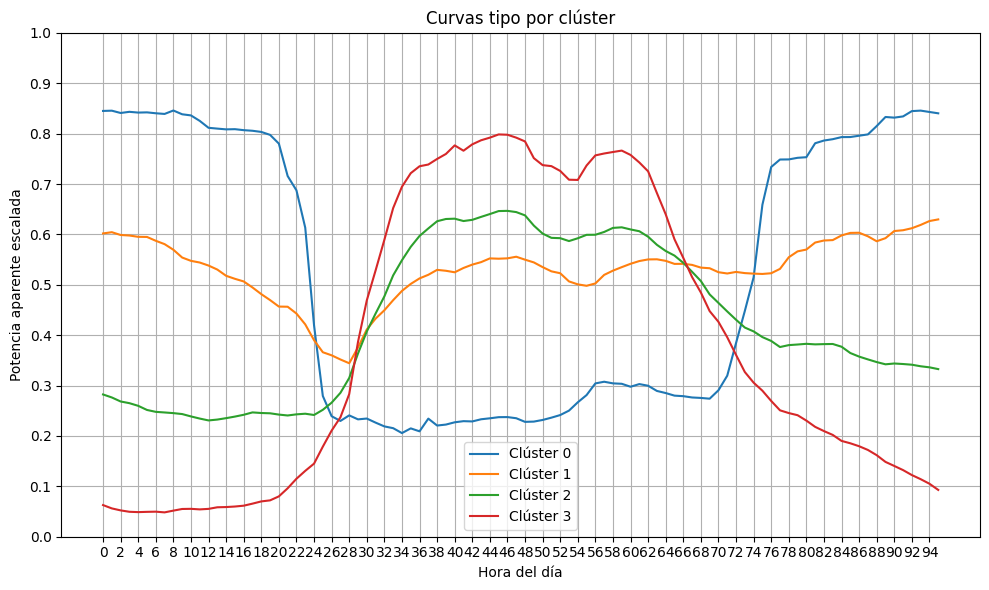

In [24]:
graficar_curva_tipo_cluster(curves_data, clusters["SpectralClustering"])

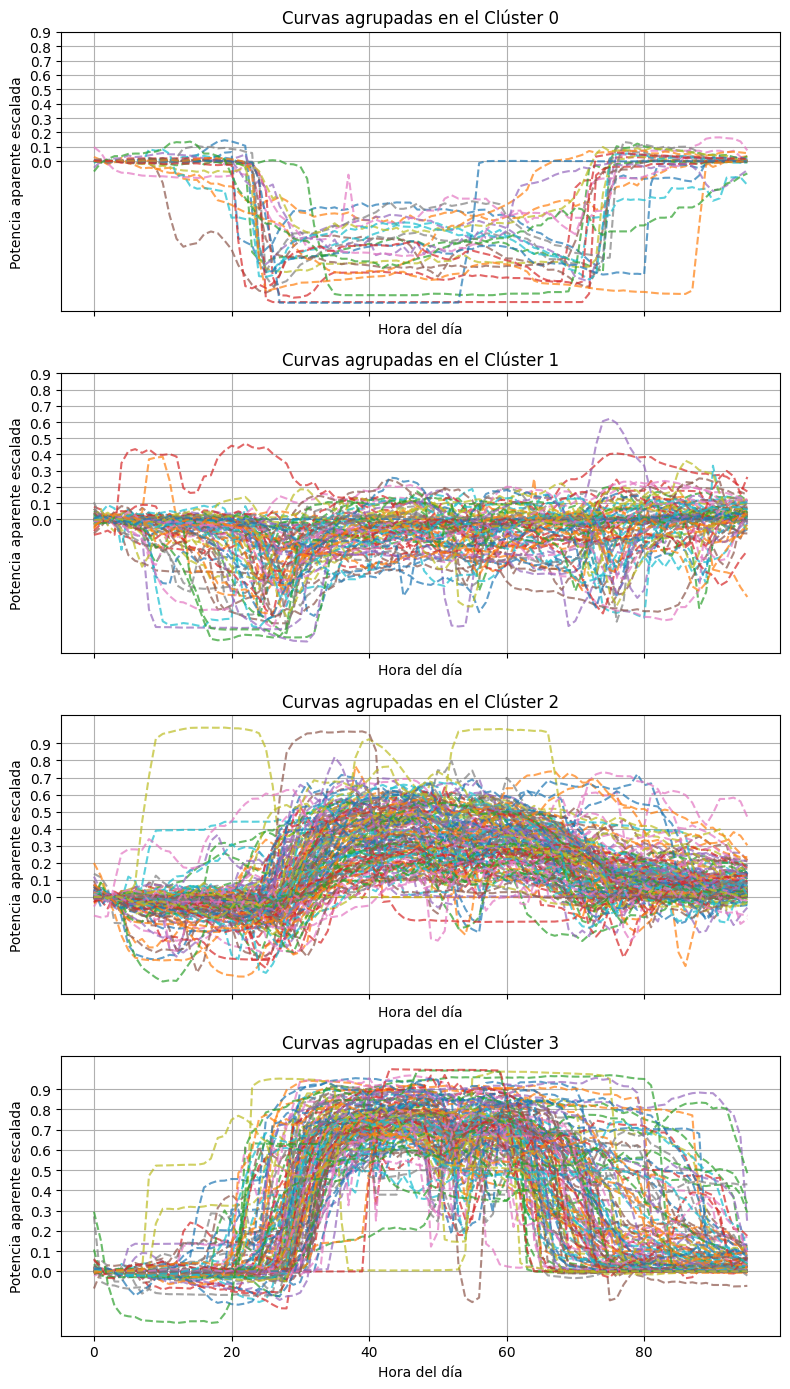

In [28]:
graficar_clusters(curvas_ajustadas, clusters["SpectralClustering"], 200)

### 6.- Comparación de Algoritmos
Se construirá una **tabla comparativa** que contendrá los siguientes indicadores de desempeño:

- **Silhouette Score**
- **SSE (Suma de Errores Cuadráticos)**
- **DBI (Índice de Davies-Bouldin)**
- **CHI (Índice de Calinski-Harabasz)**

In [25]:
df_evaluacion_algoritmos = evaluar_clustering(curvas_ajustadas, clusters)
df_evaluacion_algoritmos.to_csv(rf'../outputs/metricas_x_algoritmo.csv', index=False)
df_evaluacion_algoritmos

Métrica    KMeans  GaussianMixture     Birch  \
0  Correlación intra-clúster promedio    0.7399           0.7394    0.7515   
1                Davies-Bouldin Index    1.1791           1.2306    1.2177   
2             Calinski-Harabasz Index  283.5028         261.7910  253.3311   
3                    Silhouette Score    0.2624           0.2140    0.2326   

   SpectralClustering  
0              0.7533  
1              1.1536  
2            270.1244  
3              0.2590

---

In [30]:
df_registros_curvas

Cliente     00:00     00:15     00:30     00:45  \
0                            10103654  0.723222  0.769907  0.702453  0.728921   
1                            90000488  0.058981  0.056651  0.057228  0.055486   
2                            90000481  0.155048  0.153846  0.147059  0.142857   
3                            90001504  0.310628  0.310436  0.294643  0.317568   
4                            90001164  0.401711  0.384288  0.361851  0.366764   
..                                ...       ...       ...       ...       ...   
383       INTERFIBRA ROLAND (punto 2)  0.124415  0.128733  0.130988  0.136107   
384  NOVOPAN DEL ECUADOR ( NOVOPAN 3)  0.755209  0.776941  0.759126  0.726597   
385          PLANTAS TECNICAS PLANTEC  0.920261  0.919448  0.917169  0.917662   
386             PLASTISACKS (Punto 2)  0.675259  0.696478  0.704418  0.745081   
387               PROVEFARMA - FYBECA  0.588351  0.447175  0.232922  0.123117   

        01:00     01:15     01:30     01:45     02:00  ...     21:30  \
0    0.717130  0.712725  0.731166  0.722365  0.709922  ...  0.742358   
1    0.054735  0.054941  0.055420  0.055559  0.055094  ...  0.067711   
2    0.148148  0.156250  0.161290  0.160000  0.160000  ...  0.160000   
3    0.299356  0.301356  0.280210  0.268579  0.275386  ...  0.358224   
4    0.380571  0.394248  0.395500  0.397604  0.413474  ...  0.362813   
..        ...       ...       ...       ...       ...  ...       ...   
383  0.138962  0.134607  0.142535  0.140605  0.151124  ...  0.171379   
384  0.743483  0.736163  0.719376  0.748384  0.754622  ...  0.749869   
385  0.905742  0.904226  0.904571  0.901147  0.903036  ...  0.938083   
386  0.734876  0.714663  0.719537  0.704927  0.662964  ...  0.700060   
387  0.078954  0.071641  0.067884  0.051493  0.049427  ...  0.807090   

        21:45     22:00     22:15     22:30     22:45     23:00     23:15  \
0    0.748424  0.782108  0.748549  0.734814  0.722865  0.686218  0.668250   
1    0.066526  0.066372  0.067713  0.062954  0.064793  0.065620  0.060921   
2    0.175700  0.156250  0.117647  0.068349  0.122190  0.145503  0.172619   
3    0.378129  0.376292  0.370828  0.404976  0.368490  0.379236  0.391060   
4    0.323424  0.331992  0.408344  0.434022  0.442570  0.448411  0.444237   
..        ...       ...       ...       ...       ...       ...       ...   
383  0.183957  0.192085  0.195361  0.202808  0.213092  0.212987  0.214674   
384  0.763720  0.774639  0.760112  0.762683  0.785994  0.771255  0.787936   
385  0.942226  0.940328  0.936705  0.935516  0.938846  0.933568  0.934752   
386  0.686012  0.682817  0.669561  0.685091  0.681678  0.701994  0.708182   
387  0.796359  0.795946  0.783369  0.793014  0.799067  0.792796  0.776646   

        23:30     23:45  
0    0.640088  0.666667  
1    0.061336  0.059133  
2    0.155048  0.161290  
3    0.385823  0.363087  
4    0.445044  0.443231  
..        ...       ...  
383  0.224190  0.218039  
384  0.786241  0.789323  
385  0.932868  0.930737  
386  0.735258  0.741697  
387  0.716667  0.625838  

[388 rows x 97 columns]

### 7.- Representación gráfica de los clústeres con PCA
Se realizará una representación visual de los clústeres para ver su compacidad utilizando PCA, la cual reduce todos los datos de las curvas de carga en dos componentes, por lo que se puede generar una representación en un plano X-Y, donde cada punto es un cliente y su color represente el clúster al que ha sido asignado.

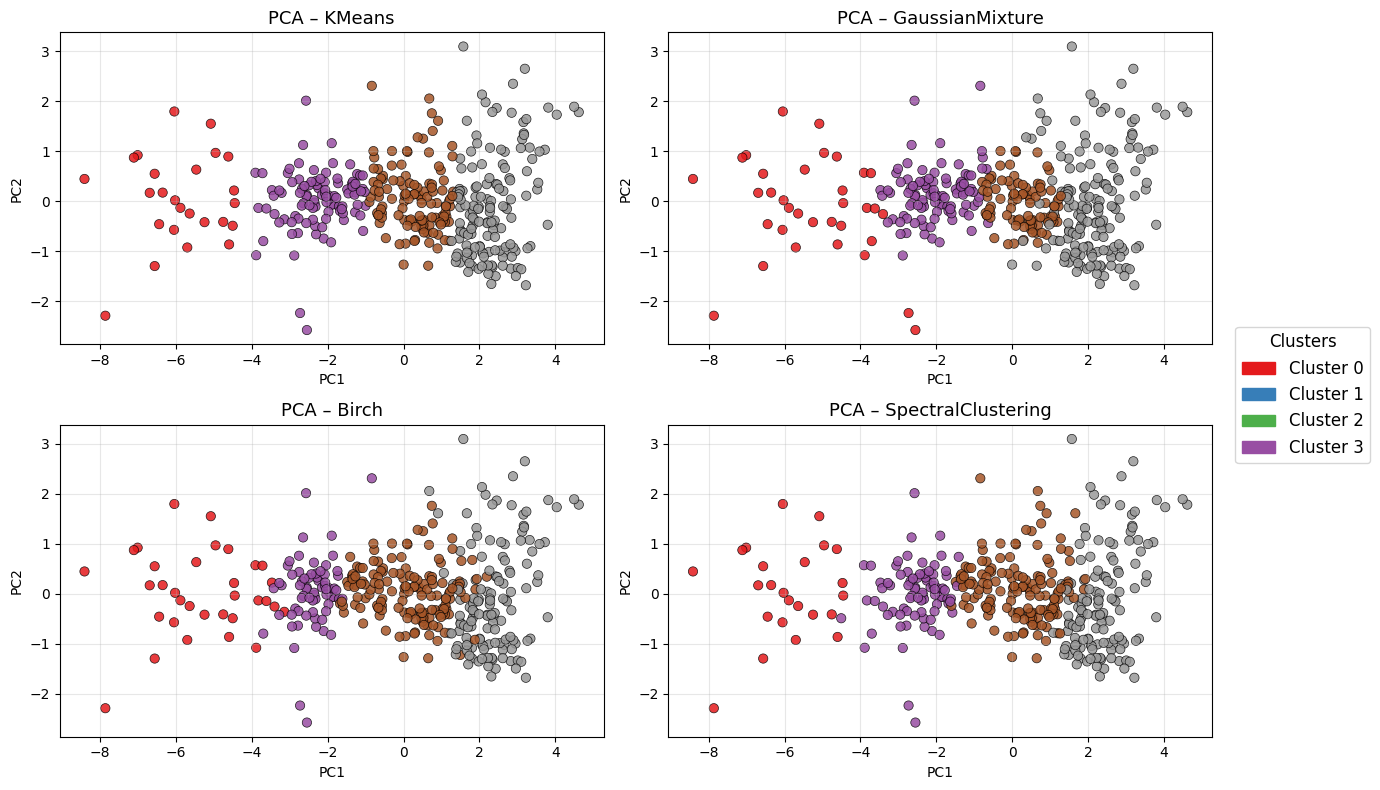

In [26]:
# === 1. PCA sobre las curvas ===
pca = PCA(n_components=2)
pca_result = pca.fit_transform(curvas_ajustadas)  # shape (n_clientes, 2)

# === 2. Lista de algoritmos para ordenarlos consistentemente ===
algoritmos = ["KMeans", "GaussianMixture", "Birch", "SpectralClustering"]

# === 3. Crear figura 2x2 ===
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.ravel()   # Convertir a vector para iterar más fácil

for i, metodo in enumerate(algoritmos):
    labels = clusters[metodo]
    ax = axes[i]

    scatter = ax.scatter(
        pca_result[:,0],
        pca_result[:,1],
        c=labels,
        cmap='Set1',
        s=45,
        alpha=0.85,
        edgecolor='k',
        linewidth=0.5
    )

    ax.set_title(f"PCA – {metodo}", fontsize=13)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3)

# === Obtener clusters únicos ===
unique_clusters = np.unique(labels)

# === Crear handles manuales ===
cmap = plt.get_cmap('Set1')
handles = [
    Patch(color=cmap(i), label=f'Cluster {i}')
    for i in unique_clusters
]

# === Leyenda general a la derecha ===
fig.legend(
    handles=handles,
    title="Clusters",
    loc='center left',
    bbox_to_anchor=(0.88, 0.5),
    fontsize=12,
    title_fontsize=12,
    frameon=True
)

# Reservar espacio para la leyenda
plt.tight_layout(rect=[0, 0, 0.88, 1])

# Agregar UNA sola barra de color para toda la figura
#cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.03, pad=0.05)
#cbar.set_label("Cluster", fontsize=12)
plt.savefig(rf'../outputs/PCA_clusters.png', format='png', dpi=400)
plt.savefig(rf'{ruta_imgs_latex}/PCA_clusters.png', format='png', dpi=400)
plt.show()


### 7.- Generar carpetas por algoritmo y clúster asignado

In [27]:
def generar_grafica(df, path, n_cluster, algoritmo):
    
    # Generar la figura
    _ = plt.figure(figsize=(16, 6))
    _ = plt.plot(df["Hora"], df["Potencia_aparente_escalada"], marker='o', color='b', linestyle='-', label='Potencia Aparente Escalada')
    _ = plt.title(f'Curva tipo para clúster #{n_cluster} del algoritmo {algoritmo}')
    _ = plt.xlabel('Hora')
    _ = plt.ylabel('Potencia Aparente Escalada')
    _ = plt.grid(True)

    # Rotar etiquetas para que no se vea acumulado el eje X
    _ = plt.xticks(df["Hora"].values[::2], rotation=45)

    # Para que no se distorsione la dimenisión del eje Y
    _ = plt.yticks(np.arange(0, 1.1, 0.1))

    # Evitar recortes en las etiquetas
    _ = plt.tight_layout()

    # Guardar la gráfica en un directorio
    _ = plt.savefig(f"{path}/curva_tipo_cluster{n_cluster}_{algoritmo}.png", format='png')  # Puedes cambiar el formato a 'jpg', 'pdf', etc.

    # Guardar las coordenadas de la curva tipo como .csv
    df.to_csv(f"{path}/curva_tipo_cluster{n_cluster}_{algoritmo}.csv", index=False)

    # Cerrar la figura
    _ = plt.close()

def generar_carpetas_algoritmos_x_cluster(dict_clusters, df_registros_curvas, path_salida = r"../outputs/clusters_x_algoritmos", path_entregables_clientes= r"../outputs/entregables_por_cliente"):

    print("---- Paso 1: Generando carpetas para los clústeres")
    # Iterar sobre cada algoritmo utilizado
    for algoritmo in list(dict_clusters.keys()):
        # Obtener los números únicos de cluster e iterar sobre cada uno
        for num_cluster in np.unique(dict_clusters[algoritmo]):
            # Verificar si existe, y si no es el caso, crearlo
            if not os.path.exists(os.path.join(path_salida,algoritmo,str(num_cluster))):
                # Crear el directorio si no existe
                os.makedirs(os.path.join(path_salida,algoritmo,str(num_cluster)), exist_ok=True)

    unido = []

    print("---- Paso 2: Copiando los entregables de los clientes en las nuevas carpetas")
    # Iterar sobre cada algoritmo y los clústers asignados
    for algoritmo, _ in dict_clusters.items():

        # Concatenar en un solo arreglo [[cliente, cluster_algoritmoXYZ_asignado]]
        unido = np.concatenate([df_registros_curvas.iloc[:,0].values.reshape(-1,1), dict_clusters[algoritmo].reshape(-1,1)], axis=1)

        # Iterar sobre cada fila del arreglo concatenado
        for fila in unido:
            cliente, cluster = fila[0], fila[1]
            destino = f"{path_salida}/{algoritmo}/{cluster}/{cliente}"

            if os.path.exists(destino):
                shutil.rmtree(destino)  # Elimina la carpeta y todo su contenido

            # Copiar el entregable a la nueva carpeta
            shutil.copytree(f"{path_entregables_clientes}/{cliente}", destino)
            
    print("---- Paso 3: Generando curvas tipo por cada clúster")
    generar_curvas_tipo_carpetas(path_salida)
    print("---- Paso 4: Generando reporte .csv de clientes por clúster asignado")
    
    list_algoritmos = list(dict_clusters.keys())
    # Generar arreglo de 388 x 4 (388 clientes con 4 atributos correspondientes a su cluster por el tipo de algoritmo)
    labels_clusteres = np.column_stack([dict_clusters[alg].reshape(-1,1) for alg in list_algoritmos])
    # Generar un dataframe con las columnas (id_cliente, #cluster_1, #cluster_2, #cluster_3, #cluster_4)
    df_reporte_clientes_x_cluster = pd.DataFrame(
        np.concat([df_registros_curvas.iloc[:,0].values.reshape(-1,1), labels_clusteres], axis=1), 
        columns = np.concat([['id_cliente'], list_algoritmos])
    )
    # Exportar el dataframe como .csv
    df_reporte_clientes_x_cluster.to_csv(rf"../outputs/reporte_clientes_x_cluster.csv", index=False)
    
    print('---- FIN GENERACIÓN ENTREGABLES CLÚSTERES ----')
            
    

def generar_curvas_tipo_carpetas(path_curvas_algoritmo_cluster="../outputs/clusters_x_algoritmos"):
    # Iterar sobre la carpeta de cada algoritmo
    for algoritmo in os.scandir(path_curvas_algoritmo_cluster):
        if algoritmo.is_dir():
            # Construir el path /path_curvas_algoritmo_cluster/nombre_algoritmo
            path_algoritmo = os.path.join(path_curvas_algoritmo_cluster, algoritmo.name)

            for n_cluster in os.scandir(path_algoritmo):
                if n_cluster.is_dir():
                    curvas_cluster = []  # Aquí guardamos todas las curvas de los clientes
                    horas_referencia = None  # Para almacenar las horas (asumiendo que son iguales en todos)

                    # Construir el path de los archivos del cliente /path_curvas_algoritmo_cluster/nombre_algoritmo/n_cluster
                    path_n_cluster = os.path.join(path_algoritmo, n_cluster.name)

                    for cliente in os.scandir(path_n_cluster):
                        if cliente.is_dir():
                            # Path al archivo CSV del cliente
                            archivo_csv = os.path.join(path_n_cluster, cliente.name, f"datos_curva_tipo_{cliente.name}.csv")
                            if os.path.exists(archivo_csv):
                                df_curva = pd.read_csv(archivo_csv).sort_values("Hora")

                                # Guardar las horas de referencia (una sola vez)
                                if horas_referencia is None:
                                    horas_referencia = df_curva["Hora"].values

                                # Guardar la curva del cliente
                                curvas_cluster.append(df_curva["Potencia_aparente_escalada"].values)

                    # Convertir a array NumPy (n_clientes, n_horas)
                    curvas_cluster = np.array(curvas_cluster)

                    # Calcular la curva media punto a punto
                    curva_media = np.mean(curvas_cluster, axis=0)

                    # Crear DataFrame con la curva media
                    df_media = pd.DataFrame({
                        "Hora": horas_referencia,
                        "Potencia_aparente_escalada": curva_media
                    })

                    # Generar gráfico y guardar datos
                    generar_grafica(df_media, path_n_cluster, n_cluster.name, algoritmo.name)

In [33]:
generar_carpetas_algoritmos_x_cluster(clusters, df_registros_curvas)

---- Paso 1: Generando carpetas para los clústeres
---- Paso 2: Copiando los entregables de los clientes en las nuevas carpetas
---- Paso 3: Generando curvas tipo por cada clúster
---- Paso 4: Generando reporte .csv de clientes por clúster asignado
---- FIN GENERACIÓN ENTREGABLES CLÚSTERES ----


### 8.- Analizar métrica de correlación intra-clúster para una muestra de clientes

In [35]:
def obtener_correlaciones_algoritmos(clusters, curvas_ajustadas, df_registros_curvas, n=183):
    
    # Obtener índice de [0, n-1] de los clientes elegidos para muestra
    np.random.seed(20030403)
    clientes_elegidos = np.random.choice(len(curvas_ajustadas)-1, n,replace=False)
    
    # Obtener en un arreglo de NumPy los identificadores de los n clientes elegidos
    arr_clientes = np.array(df_registros_curvas[df_registros_curvas.index.isin(clientes_elegidos)].reset_index(drop=True)['Cliente']).reshape(-1,1)
    
    # Para guardar correlaciones promediadas por algoritmo
    correlaciones_x_algoritmo = {}
    
    # Para guardar las correlaciones de cada cliente con su respectivo clúster
    arr_correlaciones = []
    
    # Iterar sobre cada algoritmo para obtener correlación intra-clúster promedio para la muestra de clientes
    for algoritmo in list(clusters.keys()):
        # Calcular correlación intra-clúster promedio y correlaciones por cliente y algoritmo.
        correlaciones_x_algoritmo[algoritmo], correlaciones_clientes = calcular_correlacion_intra_cluster(curvas_ajustadas, clusters[algoritmo], indices_clientes_elegidos=clientes_elegidos)
        
        
        # Guardar el nombre del algoritmo junto con las correlaciones por cliente
        arr_correlaciones.append((algoritmo, correlaciones_clientes))
        
    # Inicializar las columnas que tendrá el DataFrame final
    columnas_dataframe_corr_clientes = ['id_cliente']
    
    # Iterar sobre cada algoritmo y correlaciones por cliente
    for algoritmo, correlaciones_clientes in arr_correlaciones:
        
        # Guardar el nombre del algoritmo que se está iterando actualmente
        columnas_dataframe_corr_clientes.append(rf"corr_{algoritmo}")
        
        # Concatenar los identificadores de cliente con las correlaciones obtenidas por cliente y algoritmo
        arr_clientes = np.concatenate([arr_clientes, np.array(correlaciones_clientes).reshape(-1,1)], axis=1)
    
    # Construir DataFrame final con todas las correlaciones de los clientes por cada algoritmo
    df_correlaciones_x_cliente = pd.DataFrame(arr_clientes, columns=columnas_dataframe_corr_clientes)
    
    # Construir DataFrame final con las correlaciones promedio de la muestra de clientes por algoritmo
    df_correlaciones_x_algoritmo = pd.DataFrame(
        np.concatenate(
                       [np.array(list(correlaciones_x_algoritmo.keys())).reshape(-1,1),
                        np.array(list(correlaciones_x_algoritmo.values())).reshape(-1,1)]
                       ,axis=1
                       ), 
        columns=['Algoritmo', 'Correlación intra-clúster']
        )
    
    # Generar reporte de Excel
    with pd.ExcelWriter(rf'../outputs/resultados_muestra_clientes.xlsx', engine='xlsxwriter') as writer:
        df_correlaciones_x_cliente.to_excel(writer, sheet_name='correlaciones_x_cliente', index=False)
        df_correlaciones_x_algoritmo.to_excel(writer, sheet_name='correlaciones_x_algoritmo', index=False)
    
    # Retornar DataFrames:
    return df_correlaciones_x_algoritmo, df_correlaciones_x_cliente

In [36]:
df_corr_x_algoritmo, df_corr_x_cliente = obtener_correlaciones_algoritmos(clusters, curves_data, df_registros_curvas)

In [37]:
df_corr_x_algoritmo

Algoritmo Correlación intra-clúster
0              KMeans         0.755718099400048
1     GaussianMixture        0.7589185838808399
2               Birch         0.767106799715723
3  SpectralClustering        0.7668907975903708

In [40]:
df_corr_x_cliente

id_cliente corr_KMeans corr_GaussianMixture  \
0                            90001618    0.955124             0.954829   
1                            90002610    0.761677             0.809667   
2                             1280105    0.911018             0.906568   
3                            90000436    0.951221             0.950678   
4                            90001204    0.560748             0.599103   
..                                ...         ...                  ...   
178                         POFASA CP    0.286733             0.436297   
179               PROVEFARMA - FYBECA    0.627652             0.634799   
180                          SINTOFIL     0.81221             0.806021   
181  SOCIEDAD INDUSTRIAL RELI  CYRANO     0.06692            -0.310094   
182                    TEXTILES TEXSA     0.74056             0.727515   

    corr_Birch corr_SpectralClustering  
0     0.954624                0.956712  
1     0.790586                0.759956  
2     0.917867                0.913639  
3     0.949234                0.952802  
4     0.513449                0.462114  
..         ...                     ...  
178   0.302808                0.269766  
179   0.620986                0.617236  
180   0.818051                0.825708  
181  -0.009544               -0.001164  
182   0.667174                0.644058  

[183 rows x 5 columns]